In [1]:

# IMPORTS

import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import layers, models
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras import metrics, losses
from keras.models import load_model
import urllib.request
import os
import tarfile
from PIL import Image
import seaborn as sns
import glob

In [2]:
# Load both teacher and student models
try:
    teacher_model = load_model('teacher_model.h5')
    scratch_student = load_model('student_model.h5')
    
    # Compile teacher model
    teacher_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
    
    print("Models loaded and compiled successfully!")
except Exception as e:
    print(f"Error loading models: {str(e)}")

Models loaded and compiled successfully!


In [3]:
# Load STL-10 dataset for model extraction attack
print("Loading STL-10 training images...")
train_images = []
train_path = 'STL-10/train_images'
for img_path in glob.glob(os.path.join(train_path, '*.*')):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((32, 32))  # Resize to 32x32
    img_array = np.array(img)
    train_images.append(img_array)
X_train = np.array(train_images)

# Load test images
print("Loading STL-10 test images...")
test_images = []
test_path = 'STL-10/test_images'
for img_path in glob.glob(os.path.join(test_path, '*.*')):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((32, 32))  # Resize to 32x32
    img_array = np.array(img)
    test_images.append(img_array)
X_test = np.array(test_images)

# Normalize the data
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

# Create labels (0-9 for 10 classes)
y_train = np.zeros(len(X_train))  # We'll update these with teacher's predictions
y_test = np.zeros(len(X_test))    # We'll update these with teacher's predictions

Loading STL-10 training images...
Loading STL-10 test images...


In [4]:
# Compute student model metrics without KD
# Compute student model metrics without KD (baseline performance)
scratch_student.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)


In [5]:
# Generate training labels from teacher model predictions
print("Generating training labels from teacher model...")
train_labels = teacher_model.predict(X_train)
test_labels = teacher_model.predict(X_test)

# First, let us try to see what if we directly train the student model without using knowledge distillation
scratch_student.fit(X_train, train_labels, epochs=7, batch_size=32)

Generating training labels from teacher model...
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Epoch 1/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.2527 - loss: 2.5219 - precision: 1.0000 - recall: 0.0385
Epoch 2/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3943 - loss: 1.7197 - precision: 1.0000 - recall: 0.0367
Epoch 3/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4554 - loss: 1.5511 - precision: 1.0000 - recall: 0.0385
Epoch 4/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4827 - loss: 1.4646 - precision: 1.0000 - recall: 0.0413
Epoch 5/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5162 - loss: 1.4009 - precision: 1.0000 - recall: 0.0423
Epoch 6/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5598 - loss: 1.3325 - precision: 1.0000 - recall: 0.0454
Epoch 7/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5708 - loss: 1.2797 - precision: 1.0000 - recall: 0.0486



Evaluating student model performance without knowledge distillation:
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5176 - loss: 1.3974 - precision: 1.0000 - recall: 0.0501
Test Loss: 1.3847
Test Accuracy: 0.5238
Test Precision: 1.0000
Test Recall: 0.0503
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


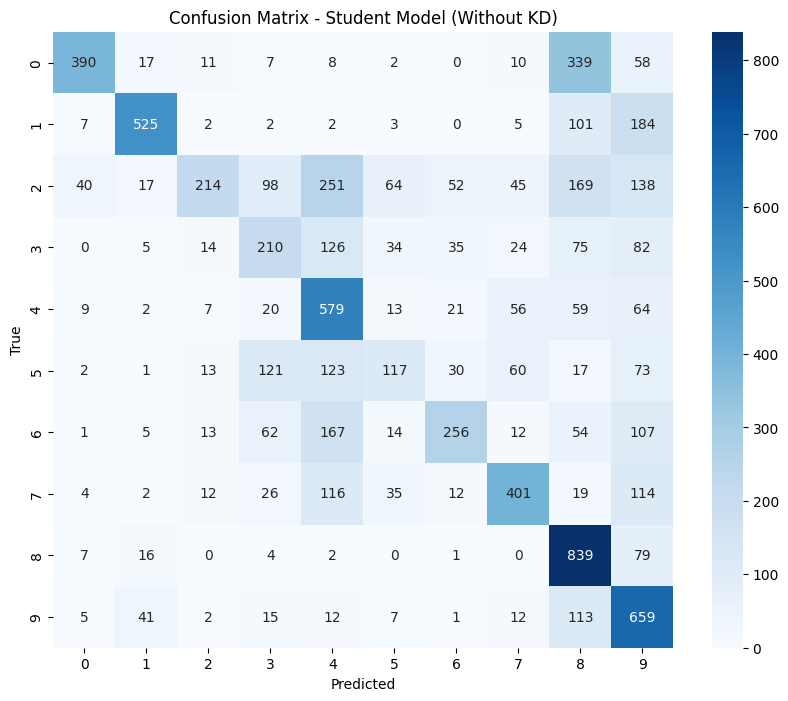

In [6]:
# We evaluate student model for its loss and accuracy, if the student model is trained without using knowledge distillation
print("\nEvaluating student model performance without knowledge distillation:")
metrics = scratch_student.evaluate(X_test, test_labels)
test_loss, test_accuracy, test_precision, test_recall = metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Keep the rest of your visualization code unchanged
# Get predictions for confusion matrix
y_pred = scratch_student.predict(X_test)
y_true = np.argmax(test_labels, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = tf.math.confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Student Model (Without KD)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [7]:
# Now let us try using knowledge distillation
# KNOWLEDGE DISTILLATION CLASS, You can adjust alpha based on how much you want the student to learn from the teacher

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.2,
        temperature=3,
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            tf.nn.softmax(teacher_pred / self.temperature, axis=1),
            tf.nn.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)


Initializing knowledge distillation training...

Training student model with knowledge distillation...
Epoch 1/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - categorical_accuracy: 0.6290 - loss: 2.0505 - precision_1: 1.0000 - recall_1: 0.0604 - val_categorical_accuracy: 0.6530 - val_loss: 2.0379 - val_precision_1: 1.0000 - val_recall_1: 0.0617
Epoch 2/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - categorical_accuracy: 0.7121 - loss: 2.0080 - precision_1: 1.0000 - recall_1: 0.0660 - val_categorical_accuracy: 0.6410 - val_loss: 2.0369 - val_precision_1: 1.0000 - val_recall_1: 0.0665
Epoch 3/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - categorical_accuracy: 0.7640 - loss: 1.9880 - precision_1: 1.0000 - recall_1: 0.0734 - val_categorical_accuracy: 0.6350 - val_loss: 2.0446 - val_precision_1: 1.0000 - val_recall_1: 0.0662
Epoch 4/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - categorical_accuracy: 0.7969 - loss: 1.9709 - precision_1: 1.0000 - recall_1: 0.0778 - val_categorical_accuracy: 0.

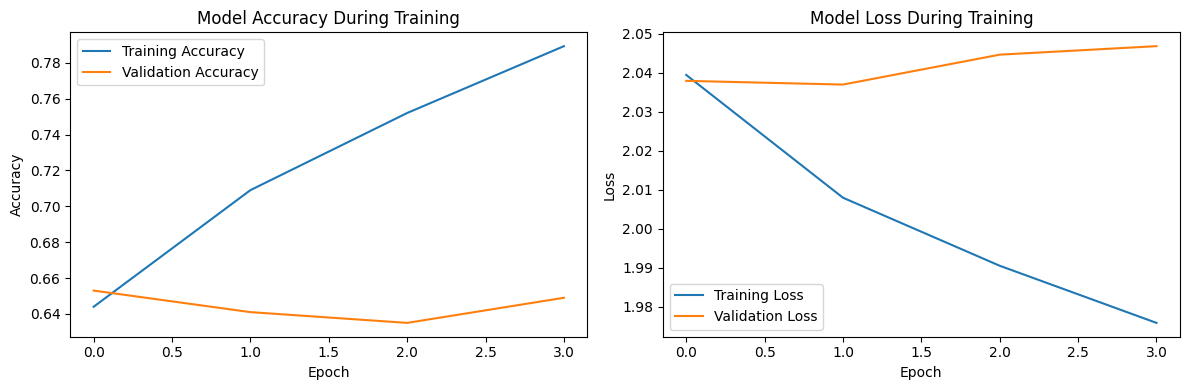

In [8]:
# Initialize the distiller
# Train the student model using knowledge distillation
print("\nInitializing knowledge distillation training...")
distiller = Distiller(student=scratch_student, teacher=teacher_model)

# Compiling the Distiller with enhanced metrics
distiller.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        keras.metrics.CategoricalAccuracy(),
        keras.metrics.Precision(),
        keras.metrics.Recall()
    ],
    student_loss_fn=keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=keras.losses.CategoricalCrossentropy(),
    alpha=0.2,  # Weight for student loss
    temperature=1,  # Temperature for softening probabilities
) 

# Fitting the student model with knowledge distillation
print("\nTraining student model with knowledge distillation...")
history = distiller.fit(
    X_train,
    train_labels,
    epochs=7,
    batch_size=32,  
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


Evaluating student model performance with knowledge distillation:
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - categorical_accuracy: 0.6028 - loss: 2.0564 - precision_1: 1.0000 - recall_1: 0.0639
Test Loss: 2.0551
Test Accuracy: 0.6120
Test Precision: 1.0000
Test Recall: 0.0653
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


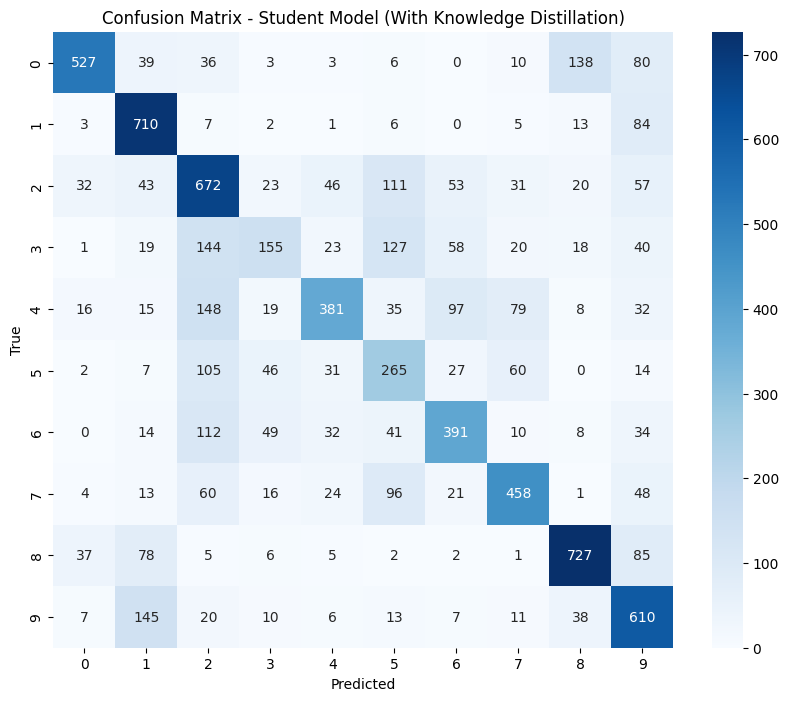


Performance Comparison:
Without Knowledge Distillation:
Accuracy: 0.5433

With Knowledge Distillation:
Accuracy: 0.6120
Improvement: 6.87%


In [9]:
# We evaluate student model again for its loss and accuracy,
# But this time the student model is trained using knowledge distillation
print("\nEvaluating student model performance with knowledge distillation:")
test_loss, test_accuracy, test_precision, test_recall = distiller.evaluate(X_test, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Get predictions for confusion matrix
y_pred = distiller.predict(X_test)
y_true = np.argmax(test_labels, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = tf.math.confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Student Model (With Knowledge Distillation)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compare with baseline performance
print("\nPerformance Comparison:")
print("Without Knowledge Distillation:")
print(f"Accuracy: {0.5433:.4f}")  # Your baseline accuracy
print("\nWith Knowledge Distillation:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Improvement: {(test_accuracy - 0.5433)*100:.2f}%")